In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
print(torch.__version__)

2.5.1+cu121


In [2]:
# create device agnosticism, but preferably should run on cuda
# I am working with Colab Pro Regular, and will be using the Tesla A100
primary_device = "cuda" if torch.cuda.is_available() else "cpu"
primary_device, torch.cuda.device_count()

('cpu', 0)

In [3]:
# data has been normalized, flattened to two dimensions, and shuffled to make it ready for the ML model
# I WANTED to use the largest size data I have, which splits the population into data points of 250 people.
# however, that leads to 1,300,000 entries. The runtime was unbelievable, because I can't find a way to parallelize the k-means cluster averaging
# so i'll be using the 1000 per data set, but if you would like to use a larger side they are available here if you copy them into the data_filename:
# cont-us-pop-flattened-250per-shuffled.csv
# cont-us-pop-flattened-500per-shuffled.csv
data_filename = 'cont-us-pop-flattened-1000per-shuffled.csv'

# I am hosting the data on my personal site
data_url = 'https://www.tyro.work/' + data_filename
data_local_path = '/content/' + data_filename
# use bash command on colab to get the data from the url
if not os.path.exists(data_local_path):
  !wget $data_url
else:
  print("Flattened Population Data has already been downloaded.")

--2024-11-25 02:54:11--  https://www.tyro.work/cont-us-pop-flattened-1000per-shuffled.csv
Resolving www.tyro.work (www.tyro.work)... 162.244.93.7, 2602:faa9:1008:918:fd16:9073:7cff:b175
Connecting to www.tyro.work (www.tyro.work)|162.244.93.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14885980 (14M) [text/csv]
Saving to: ‘cont-us-pop-flattened-1000per-shuffled.csv’

cont-us-pop-flatten 100%[===================>]  14.20M  8.76MB/s    in 1.6s    

2024-11-25 02:54:14 (8.76 MB/s) - ‘cont-us-pop-flattened-1000per-shuffled.csv’ saved [14885980/14885980]



In [4]:
""" Here I wanted to create an example to demonstrate how the torch.cdist works.
cdist is how we're going to be calculating our distance and is going to be the crux of our k-means algorithm
we have two 2d tensors, but I wasn't sure whether to organize them as shape [2, x] or [x, 2] where x is the number of samples
we need to shape our tensors to match how this function works
"""
import math

x = torch.tensor([[1, 2], [3, 4], [6,9], [420, 69]], dtype=torch.float64)
y = torch.tensor([[5, 6], [7, 8], [6,9]], dtype=torch.float64)

manual_calc = math.sqrt((5 - 6) ** 2 + (6 - 9) ** 2)
print('manual calculation of euclidian distance: ', manual_calc) # taking x[2] and y[0]
dist = torch.cdist(x, y, p=2)  # p=2 for Euclidean distance
print(dist, dist.shape) # you can see that x[2], y[0] matches with dist[2][0]
print('cdist calculation: ', dist[2][0].item(), 'matches: ', dist[2][0].item() == manual_calc)


manual calculation of euclidian distance:  3.1622776601683795
tensor([[  5.6569,   8.4853,   8.6023],
        [  2.8284,   5.6569,   5.8310],
        [  3.1623,   1.4142,   0.0000],
        [419.7547, 417.4805, 418.3252]], dtype=torch.float64) torch.Size([4, 3])
cdist calculation:  3.1622776601683795 matches:  True


as you can see, the examples are organized by [x, 2] so that's how we will shape our tensors


what that means for us is that when we get our data we want to take the vector of longitudes (x axis) and vector of latitudes (y axis). Importing them from pandas will create a list of values which will create a [1,x] shape tensor.

So that means we need to reshape the two rows of lat and lng values into shape (-1, 1) so that they're stacked on top of each other.

When we have a vertical stack of values, then we can hstack the two tensors to combine them into a tensor of [[lng, lat], [lng, lat], ...]

In [5]:
# use pandas to access the csv we downloaded and turn it into PyTorch tensor
data_frame = pd.read_csv(data_local_path)
# convert data frame into a tensor
lat_tensor = torch.tensor(data_frame['lat'].values)
lat_tensor = lat_tensor.reshape(-1, 1)
lng_tensor = torch.tensor(data_frame['lng'].values)
lng_tensor = lng_tensor.reshape(-1, 1)
# CAREFUL - latitude is how far up and down so it's y axis, lng is left right and it's x axis
lnglat_tensor = torch.hstack((lng_tensor, lat_tensor))
lnglat_tensor, lnglat_tensor.shape, lnglat_tensor[0], lnglat_tensor[:, 0], lnglat_tensor[:, 1]

(tensor([[  3.6800,   3.1637],
         [-20.1119,  -2.4426],
         [ 15.3563,  -1.6035],
         ...,
         [-27.9576,   0.6310],
         [-26.5661,  -3.9594],
         [ 17.3530,   3.1209]], dtype=torch.float64),
 torch.Size([328911, 2]),
 tensor([3.6800, 3.1637], dtype=torch.float64),
 tensor([  3.6800, -20.1119,  15.3563,  ..., -27.9576, -26.5661,  17.3530],
        dtype=torch.float64),
 tensor([ 3.1637, -2.4426, -1.6035,  ...,  0.6310, -3.9594,  3.1209],
        dtype=torch.float64))

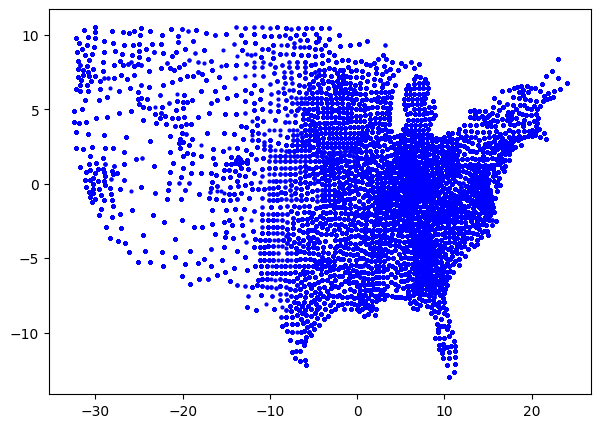

In [6]:
# let's create a plotting device for our data points
def plot_inputs(input_tensor):
  plt.figure(figsize = (7,5))
  plt.scatter(input_tensor[:, 0], input_tensor[:, 1], c='b', s=4, label='data points')

plot_inputs(lnglat_tensor)

--2024-11-25 02:54:22--  https://www.tyro.work/cont-us-counties-latlng-normalized.csv
Resolving www.tyro.work (www.tyro.work)... 162.244.93.7, 2602:faa9:1008:918:fd16:9073:7cff:b175
Connecting to www.tyro.work (www.tyro.work)|162.244.93.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 306413 (299K) [text/csv]
Saving to: ‘cont-us-counties-latlng-normalized.csv’

cont-us-counties-la 100%[===================>] 299.23K   513KB/s    in 0.6s    

2024-11-25 02:54:23 (513 KB/s) - ‘cont-us-counties-latlng-normalized.csv’ saved [306413/306413]

county data shape:  torch.Size([3109, 2])
county data:  tensor([[-26.5661,  -3.9594],
        [  3.8418,   3.5588],
        [ -3.7352,  -8.4235],
        ...,
        [ -8.5972,  -4.6648],
        [ -6.0431, -11.3528],
        [-11.9214,  -6.4320]], dtype=torch.float64)


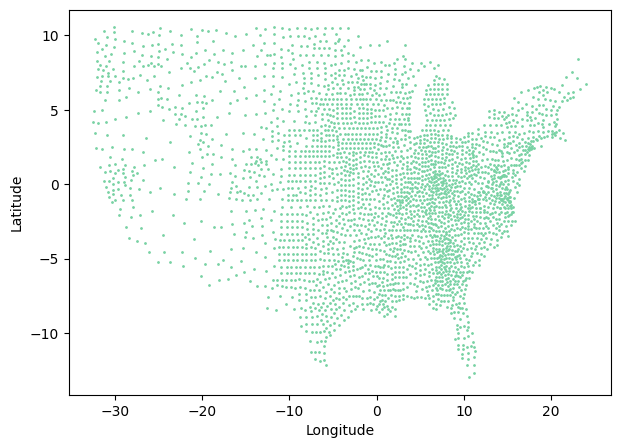

In [7]:
# perfect. so that is great to see that it's working, but we don't need to draw all 1,300,000 points overtop of each other just to show the map.
# so let's import the unflattened data just to display everything with less draw time

# repeat the same steps we did before to format the data
drawing_data = 'https://www.tyro.work/cont-us-counties-latlng-normalized.csv'
if not os.path.exists('/content/cont-us-counties-latlng-normalized.csv'):
  !wget $drawing_data
else:
  print("County Location Data has already been downloaded.")

drawing_df = pd.read_csv('/content/cont-us-counties-latlng-normalized.csv')
draw_lat_tensor = torch.tensor(drawing_df['lat'].values)
draw_lat_tensor = draw_lat_tensor.reshape(-1, 1)
draw_lng_tensor = torch.tensor(drawing_df['lng'].values)
draw_lng_tensor = draw_lng_tensor.reshape(-1, 1)
# i thought we needed to vstack these, but we actually need hstack
draw_lnglat_tensor = torch.hstack((draw_lng_tensor, draw_lat_tensor))
print("county data shape: ", draw_lnglat_tensor.shape)
print('county data: ', draw_lnglat_tensor)
# these constants will be useful for randomizing our centroids
lat_max = draw_lat_tensor.max().item()
lat_min = draw_lat_tensor.min().item()
lng_max = draw_lng_tensor.max().item()
lng_min = draw_lng_tensor.min().item()

def draw_counties():
  plt.figure(figsize = (7,5))
  plt.scatter(draw_lnglat_tensor[:, 0], draw_lnglat_tensor[:, 1], c='#79d2a4', marker='.', s=4, label='U.S. Counties')
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')

# now we have a method to quickly draw the county locations
draw_counties()

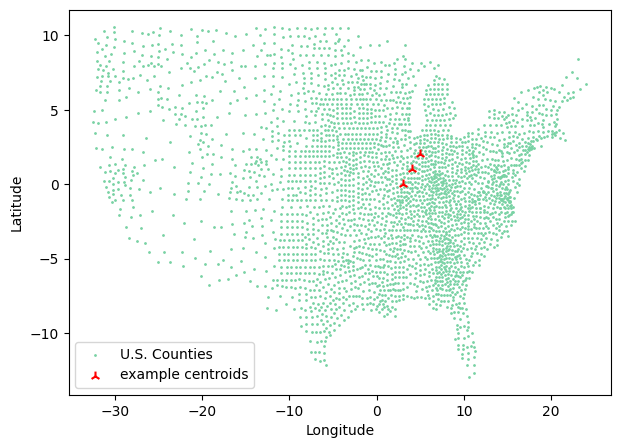

In [8]:
x = [0, 1, 2]
y = [3, 4, 5]
draw_counties()
plot2 = plt.scatter(x, y, c='r', s=50, marker='2', label='example centroids')
plot3 = plt.scatter(y, x, c='r', s=50, marker='2', label='example centroids')
plt.legend()

plot2.remove()
del plot2
plt.legend()
# just an example of checking to see how our centroids will look over top of the county data
# with an example testing how the clf function works
# using remove and del instead

In [9]:
# loss function
def find_closest_centroids_and_loss(X, centroids):
  """ compute the centorid memberships for each example
  we need to return two tensors:
    one that will return the indices of the centroid closest to each example
    one that will contain all of the loss for each example (min_dist by euclidian distance)
  """
  # cdist(X, centroids) produces a tensor where each row represents an input X, and each y is the euclidian distance to the centroid there
  euclidian_dist_to_centroids = torch.cdist(X, centroids, p=2)
  # rather than using .min and then .argmin to get the min and argmin, you can use a dimension argument in min to get both at the same time
  min_dist, argmin_indices = torch.min(euclidian_dist_to_centroids, dim=1)
  return (argmin_indices, min_dist)

Beginning Seed 0 for k_means 20
  wloop 0 - cur loss: 823408.5733074554, prev loss: None
  wloop 1 - cur loss: 604193.1172834514, prev loss: 823408.5733074554
  wloop 2 - cur loss: 554935.1806794652, prev loss: 604193.1172834514
  wloop 3 - cur loss: 516680.01208270947, prev loss: 554935.1806794652
  wloop 4 - cur loss: 484447.1113633876, prev loss: 516680.01208270947
  wloop 5 - cur loss: 464485.8014294667, prev loss: 484447.1113633876
  wloop 6 - cur loss: 461882.69616947114, prev loss: 464485.8014294667
  wloop 7 - cur loss: 461652.19419904775, prev loss: 461882.69616947114
  wloop 8 - cur loss: 461681.93098651833, prev loss: 461652.19419904775
  wloop 9 - cur loss: 461671.7632164328, prev loss: 461681.93098651833
  seed 0 converged at while loop 10. 
    prev lowest loss: inf, 
    cur seed loss: 461671.7632164328
  ✓ seed 0 performed better than previous best, seed -1
Beginning Seed 1 for k_means 20
  wloop 0 - cur loss: 1112191.5576042868, prev loss: None
  wloop 1 - cur loss: 62

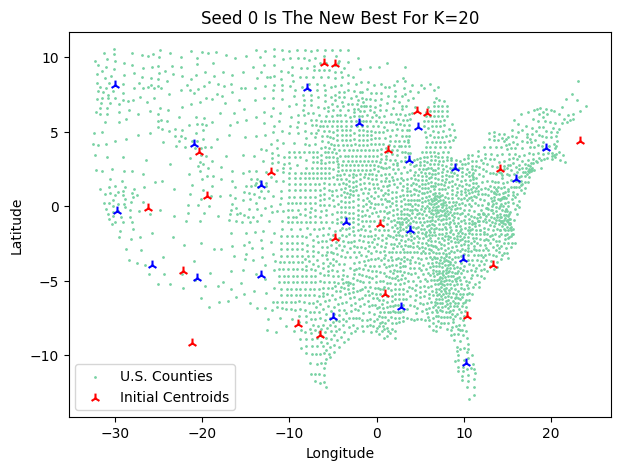

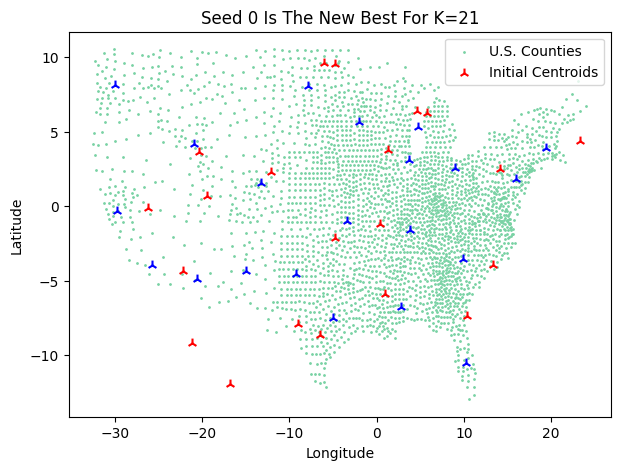

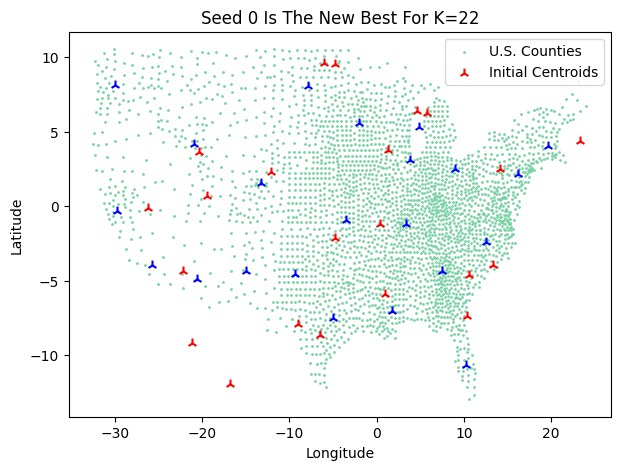

In [11]:
# now it's time to set up our k-means
# we want to pick the number of starting centroids (k), I believe that's our only input variable
LAT_RANGE = lat_max - lat_min + 1
LNG_RANGE = lng_max - lng_min + 1
LAT_SHIFT = lat_min # the shifts are negative values, so add them not subtract
LNG_SHIFT = lng_min
# print(LAT_RANGE, LNG_RANGE, LAT_SHIFT, LNG_SHIFT)
US_COUNTIES = 3109 # there are 3109 counties listed in our data of the continental united states.

# what do we need to save to display at the end when this is all done?
# for our analysis, what we NEED is the lowest cost for each k, and the final centroid locations after performing k-means
# furthermore from that I would also like to know 1. which seed produced that, 2. original centroid positions, 3. final loss for other seeds, 4. final centroid count
# so we'll track all of those values.

# you cannot use cdist on an empty tensor so k_means(0) does not work, but I want the index number to correlate with the k directly for later
# I've initialized these values with garbage data at the 0th index so that everything syncs
k_best_seeds = [0]
k_losses = [0]
k_best_init_centroids = [0]
k_best_final_centroids = [0]
k_all_seeds_resulting_loss = [0]
k_best_centroid_count = [0]

# finally, we need to split our data into a training set and a testing set
# I want to use 250000 data points for my model just because it's a cool number. it's about 76% of the dataset. So if you're using the larger training sets I'm setting it up to use 75% for data and 25% for testing
test_split = 250000 if data_filename == 'cont-us-pop-flattened-1000per-shuffled.csv' else (len(lnglat_tensor[0]) * 3) // 4
training_set = lnglat_tensor[:test_split, :]
testing_set = lnglat_tensor[test_split:, :]
# print(training_set.shape, testing_set.shape, training_set, testing_set)
N = training_set.shape[0]

def k_means(k):
  ''' our k means function takes a number of initial centroids, k, and randomizes them to points across the map.
  we repeatedly assign all the points to their closest centroid, find the average of the points associated with the centroid, and move it.
  Eventually the centroids find a position where they will no longer move and that is where we can calculate the final loss of the k means.
  This k means function will perform this process across 100 starting seeds to try to make sure a result is not caused by localized minima.
  finally, when the k means has found the optimal solution out of the 100 seeds, we will store the results in an array for later comparison.
  '''
  # these are the variables we want to track
  best_seed = -1
  lowest_loss = float('inf')
  best_init_centroids = None
  best_final_centroids = None
  all_seeds_resulting_loss = []
  best_centroid_count = -1

  # we want to perform 100 different randomizations for the starting points
  for seed in range(5):
    print(f'Beginning Seed {seed} for k_means {k}')
    cur_k = k

    torch.manual_seed(seed)
    init_centroids = torch.rand(k, 2, dtype=torch.float64)
    # to turn a range from 0 to 1 into our latitudes and longitudes we can:
    # multiply the random by the range, and then shift by the minimum
    init_centroids[:, 0] = init_centroids[:, 0] * LNG_RANGE + LNG_SHIFT
    init_centroids[:, 1] = init_centroids[:, 1] * LAT_RANGE + LAT_SHIFT
    # the preferred way to clone tensors is as such:
    centroids = init_centroids.clone().detach()

    closest_centroid, losses = find_closest_centroids_and_loss(training_set, centroids)
    # print('initial closest centroids: ', init_closest)
    # print('initial losses: ', losses)

    # now we just need to initialize the sum of losses to begin our k-means descent
    sum_losses = losses.sum()
    # print(sum_losses)

    prev_loss_sum = None
    while_count = 0
    while sum_losses != prev_loss_sum:
      print(f'  wloop {while_count} - cur loss: {sum_losses}, prev loss: {prev_loss_sum}')
      # 1. all points associated with each centroid, and average them.
      count = [0] * cur_k
      avg_x = [0] * cur_k
      avg_y = [0] * cur_k
      # print('training set: ', training_set, 'x value: ', training_set[0][0])
      for i in range(N):
        cur = closest_centroid[i]
        count[cur] += 1
        avg_x[cur] += training_set[i][0].item()
        avg_y[cur] += training_set[i][1].item()

      next_centroids = []
      # 2. create a new set of centroids based on the positional average for each, removing any with 0 points associated because they will average to nothing
      for i in range(cur_k):
        if count[i] > 0:
          next_centroids.append([avg_x[i] / count[i], avg_y[i] / count[i]])
      centroids = torch.tensor(next_centroids, dtype=torch.float64)
      # 2.5 update k with the new number of centroids
      cur_k = len(next_centroids)

      # 3. calculate the loss and new associations of the centroids
      closest_centroid, losses = find_closest_centroids_and_loss(training_set, centroids)

      # 4. update prev_loss_sum = sum_losses, sum_losses is our new data, and centroids should be updated to the new positions
      prev_loss_sum = sum_losses
      sum_losses = losses.sum()
      # 5. increment while loop count for debugging
      while_count += 1

    # finally when we finish our while loop we have a finalized loss and centroid positions.
    print(f'  seed {seed} converged at while loop {while_count}. \n    prev lowest loss: {lowest_loss}, \n    cur seed loss: {sum_losses}')
    # compare the final loss to our best loss, and if we have found a better option update all of our best values
    if (sum_losses < lowest_loss):
      print(f'  ✓ seed {seed} performed better than previous best, seed {best_seed}')
      best_seed = seed
      lowest_loss = sum_losses
      best_init_centroids = init_centroids
      best_final_centroids = centroids
      best_centroid_count = cur_k
      # when we find a new seed that's better let's plot that one
      draw_counties()
      plt.scatter(init_centroids[:, 0], init_centroids[:, 1], c='r', s=50, marker='2', label='Initial Centroids')
      plt.title(f'Seed {seed} Is The New Best For K={k}')
      plt.legend()
      cur_plot = plt.scatter(centroids[:, 0], centroids[:, 1], c='b', s=50, marker='2', label='Optimized Centroids')

    # no matter what add the loss so we can see them across all seeds
    all_seeds_resulting_loss.append(sum_losses)



  # after going through all the seeds we will be testing it's time to push our data into the storage lists
  k_best_seeds.append(best_seed)
  k_losses.append(lowest_loss)
  k_best_init_centroids.append(best_init_centroids)
  k_best_final_centroids.append(best_final_centroids)
  k_all_seeds_resulting_loss.append(all_seeds_resulting_loss)
  k_best_centroid_count.append(best_centroid_count)

# the number of US Counties represents our max possible data clusters
for i in range(20, 23): # US_COUNTIES + 1
  k_means(i)

# debugging - just observing our data storage
# after going through all the seeds we will be testing it's time to push our data into the storage lists
print('finished going through all k means, here are the results:')
print('Resulting Best Seeds:')
print(k_best_seeds)
print('Resulting Best Losses:')
print(k_losses)
print('Resulting Best Init Centroids:')
print(k_best_init_centroids)
print('Resulting Best Final Centroids:')
print(k_best_final_centroids)
print('Resulting Losses From All Seeds:')
print(k_all_seeds_resulting_loss)
print('Resulting Best Centroid Counts:')
print(k_best_centroid_count)
# finally we need to save the data in the storage lists to a pytorch file.